# SARIMA mode
Feb 24th 2022

In [1]:
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import os
print(os.getcwd())
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm #help us to select p,d,q
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
# pd.options.display.float_format = '{:,.6f}'.format
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (13, 5)
plt.rcParams['figure.figsize']= plotsize

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/coursera_time_series/week_3/2_arima_sarima_models


In [2]:
# Custom functions:
from src.timeseriesFunctions import get_years

## Playtoy to understand differencing

In [32]:
play= pd.DataFrame([[i for i in range(1,11)], [i**2 for i in range(1,11)]]).T
play.columns = ["original", "squared"]
display(play)

# Plot
# plt.plot(play.original, play.squared)
# plt.show()

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [25]:
play.original.diff()

0    NaN
1   1.00
2   1.00
3   1.00
4   1.00
5   1.00
6   1.00
7   1.00
8   1.00
9   1.00
Name: original, dtype: float64

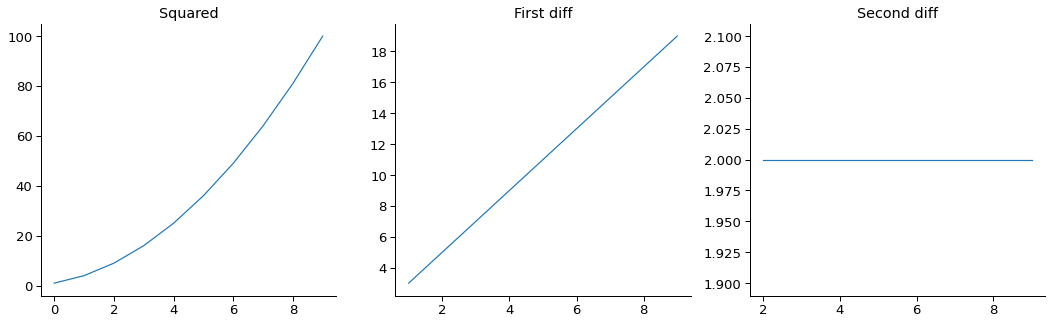

In [40]:
fig, axes = plt.subplots(1,3, figsize= (18,5))

axes[0].plot(play.squared)
axes[0].set_title("Squared")
axes[1].plot(play.squared.diff())
axes[1].set_title("First diff")
axes[2].plot(play.squared.diff().diff())
axes[2].set_title("Second diff")

plt.show()

In [41]:
play.squared.diff().diff()

0    NaN
1    NaN
2   2.00
3   2.00
4   2.00
5   2.00
6   2.00
7   2.00
8   2.00
9   2.00
Name: squared, dtype: float64

## Data Preparation and EDA

In [32]:
data= "./course_data/"
monthly_temp= pd.read_csv(data+"mean-monthly-temperature-1907-19.csv", 
                          names= ["month", "temp"], skipfooter= 2, engine= 'python',
                          infer_datetime_format= True, header= 0, index_col= 0)
monthly_temp.index= pd.to_datetime(monthly_temp.index)
# 'A'= annually
annual_temp=  monthly_temp.resample('A').mean()
monthly_temp

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8
...,...
1972-08-01,75.6
1972-09-01,64.1
1972-10-01,51.7


In [3]:
monthly_temp.describe()

,temp
count,792.00
mean,53.55
std,15.82
min,11.20
25%,39.68
50%,52.15
75%,67.20
max,82.40


In [13]:
get_years(monthly_temp)

Number of unique years: 66

['1907' '1908' '1909' '1910' '1911' '1912' '1913' '1914' '1915' '1916'
 '1917' '1918' '1919' '1920' '1921' '1922' '1923' '1924' '1925' '1926'
 '1927' '1928' '1929' '1930' '1931' '1932' '1933' '1934' '1935' '1936'
 '1937' '1938' '1939' '1940' '1941' '1942' '1943' '1944' '1945' '1946'
 '1947' '1948' '1949' '1950' '1951' '1952' '1953' '1954' '1955' '1956'
 '1957' '1958' '1959' '1960' '1961' '1962' '1963' '1964' '1965' '1966'
 '1967' '1968' '1969' '1970' '1971' '1972']


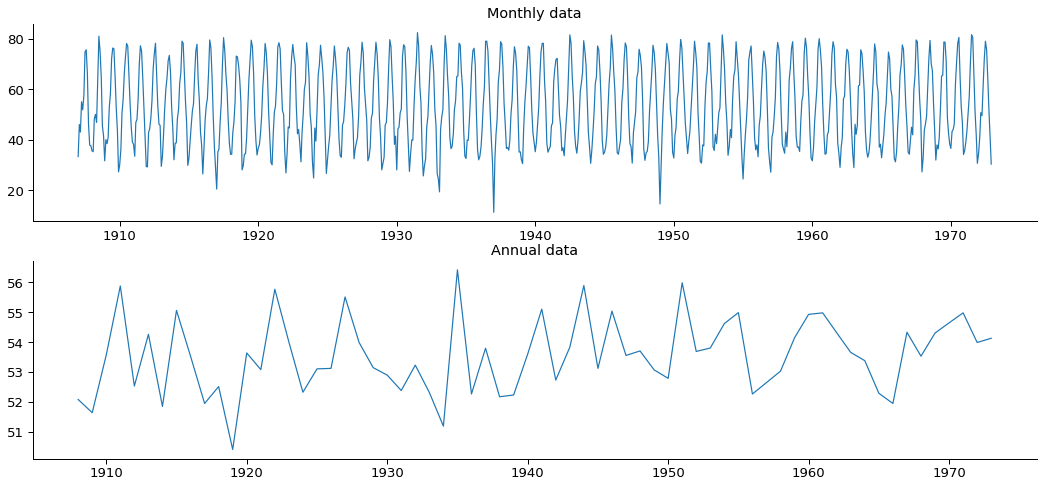

In [33]:
# Plot the temperature per year
fig, axes = plt.subplots(2,1, figsize= (18, 8))

axes[0].plot(monthly_temp)
axes[0].set_title("Monthly data")
axes[1].plot(annual_temp)
axes[1].set_title("Annual data")

plt.show()

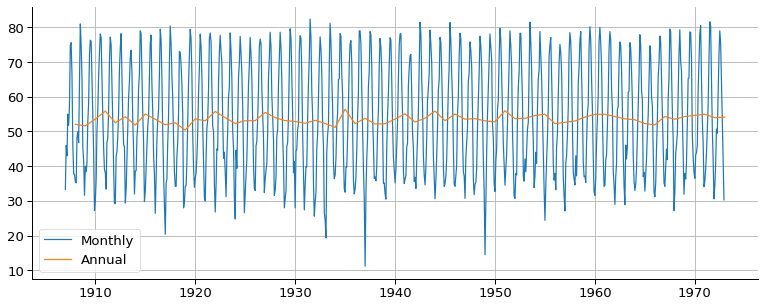

In [34]:
plt.plot(monthly_temp, label= "Monthly")
plt.plot(annual_temp, label= "Annual")
plt.legend()
plt.grid()
plt.show()

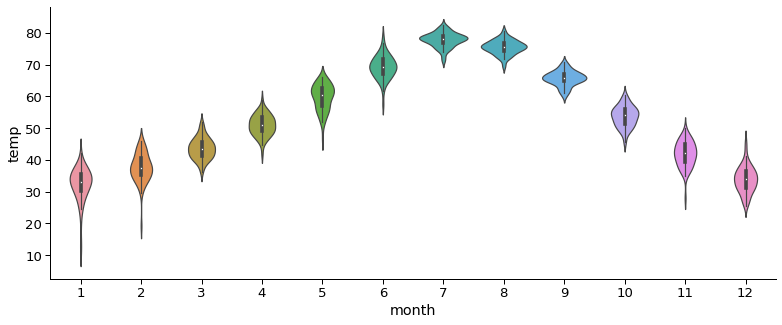

In [35]:
sns.violinplot(x= monthly_temp.index.month, y= monthly_temp.temp)
plt.show()
# sns.boxplot(x= monthly_temp.index.month, y= monthly_temp.temp)
# plt.show()

In [36]:
# Differencing by season:
monthly_temp['lag_12']= monthly_temp.shift(12)
display(monthly_temp.head(14))
monthly_temp['seasonal_diff']= monthly_temp.temp - monthly_temp.lag_12
display(monthly_temp.head(14))
# Log transformation for differencing by season
monthly_temp['seasonal_diff_log']= np.log10(np.array(monthly_temp.seasonal_diff) + monthly_temp.seasonal_diff.max())
display(monthly_temp.head(14))

,temp,lag_12
month,,
1907-01-01,33.3,NaN
1907-02-01,46.0,NaN
1907-03-01,43.0,NaN
1907-04-01,55.0,NaN
1907-05-01,51.8,NaN
1907-06-01,57.5,NaN
1907-07-01,74.8,NaN
1907-08-01,75.6,NaN
1907-09-01,66.3,NaN


,temp,lag_12,seasonal_diff
month,,,
1907-01-01,33.3,NaN,NaN
1907-02-01,46.0,NaN,NaN
1907-03-01,43.0,NaN,NaN
1907-04-01,55.0,NaN,NaN
1907-05-01,51.8,NaN,NaN
1907-06-01,57.5,NaN,NaN
1907-07-01,74.8,NaN,NaN
1907-08-01,75.6,NaN,NaN
1907-09-01,66.3,NaN,NaN


,temp,lag_12,seasonal_diff,seasonal_diff_log
month,,,,
1907-01-01,33.3,NaN,NaN,NaN
1907-02-01,46.0,NaN,NaN,NaN
1907-03-01,43.0,NaN,NaN,NaN
1907-04-01,55.0,NaN,NaN,NaN
1907-05-01,51.8,NaN,NaN,NaN
1907-06-01,57.5,NaN,NaN,NaN
1907-07-01,74.8,NaN,NaN,NaN
1907-08-01,75.6,NaN,NaN,NaN
1907-09-01,66.3,NaN,NaN,NaN


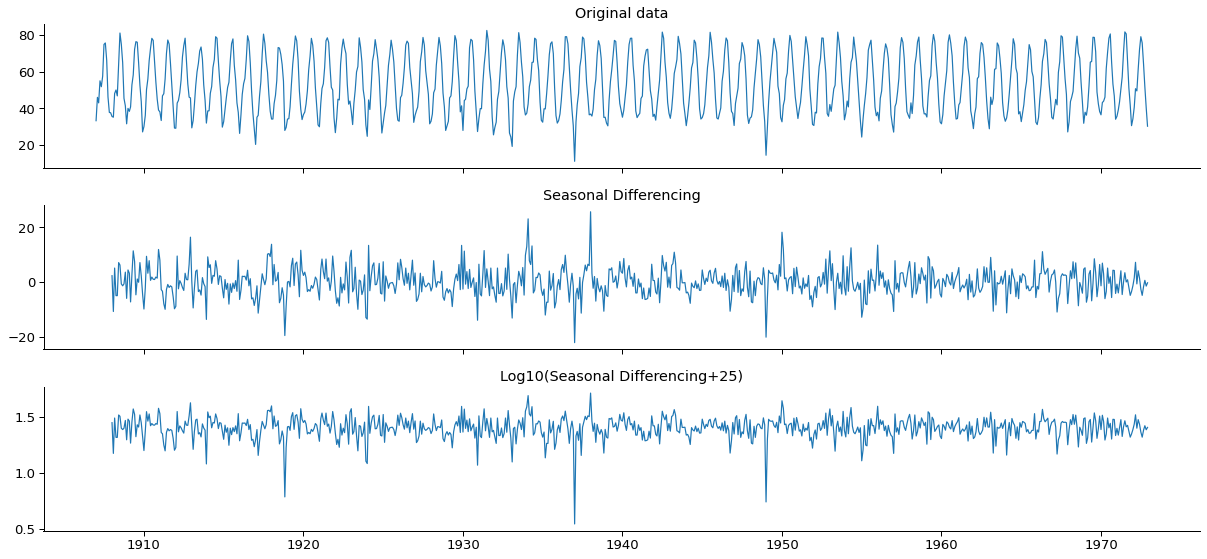

In [37]:
fig, axes = plt.subplots(3,1, figsize= (17,8), sharex= True)

axes[0].plot(monthly_temp.temp)
axes[0].set_title("Original data")

axes[1].plot(monthly_temp.seasonal_diff)
axes[1].set_title("Seasonal Differencing")

axes[2].plot(monthly_temp.seasonal_diff_log)
axes[2].set_title("Log10(Seasonal Differencing+25)")

plt.tight_layout()
plt.show()

In [38]:
def dickey_fuller_test(timeseries):
    """
    NUll hypothesis= time-series is not stationary
    """
    test= adfuller(timeseries)
    df= pd.Series(test[0:4], index= ["Test-statistics", "p-value", "Lags-used", "Observation-used"])
    for key,value in test[4].items():
        df['Critical value (%s)'%key] = value    
    print(df)
    # Rolling
    rolmean= timeseries.rolling(window=12).mean()
    rolstd= timeseries.rolling(window=12).std()
    # Plotting
    original= plt.plot(timeseries, color= "blue", label= "Original Time-series")
    mean= plt.plot(rolmean, color= "red", label= "Rolling Mean")
    std= plt.plot(rolstd, color= "black", label= "Rolling Std")
    plt.legend(loc= "best")
    plt.grid()
    plt.show()

Test-statistics        -6.481466e+00
p-value                 1.291867e-08
Lags-used               2.100000e+01
Observation-used        7.700000e+02
Critical value (1%)    -3.438871e+00
Critical value (5%)    -2.865301e+00
Critical value (10%)   -2.568773e+00
dtype: float64


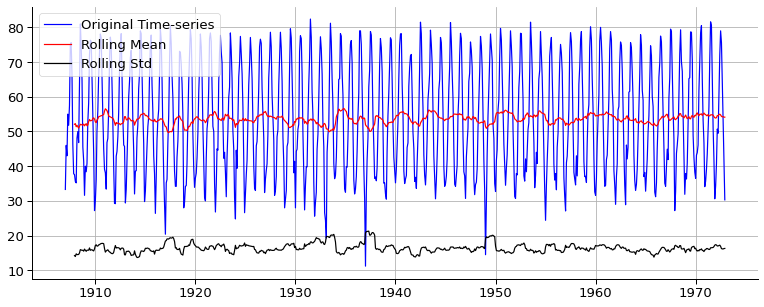

In [39]:
dickey_fuller_test(monthly_temp.temp)

Test-statistics        -7.878242e+00
p-value                 4.779473e-12
Lags-used               0.000000e+00
Observation-used        6.500000e+01
Critical value (1%)    -3.535217e+00
Critical value (5%)    -2.907154e+00
Critical value (10%)   -2.591103e+00
dtype: float64


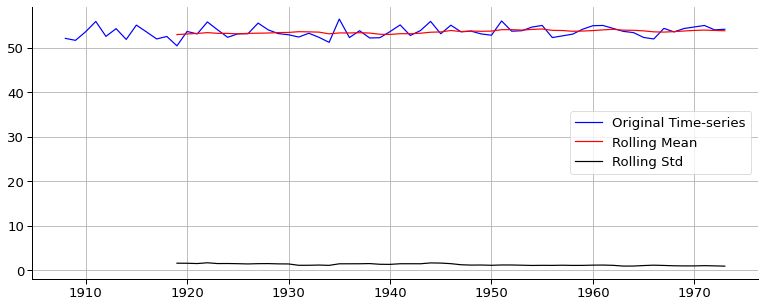

In [40]:
dickey_fuller_test(annual_temp.temp)